In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-30 10:21:16.651450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 10:21:16.724242: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 10:21:17.150090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_084


In [2]:
oof_df = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
# oof_df = oof_df[oof_df["series_id"].isin(oof_df["series_id"].unique()[:50])]
oof_df.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.017602,0.000630
1,05e1944c3818,18,0.013808,0.000534
2,05e1944c3818,30,0.013164,0.000526
3,05e1944c3818,42,0.013909,0.000502
4,05e1944c3818,54,0.014793,0.000486


1038324

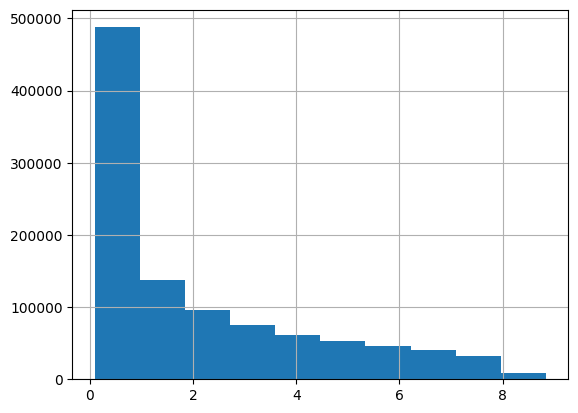

In [3]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.1]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.1]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["step"] = train["step"].astype(int)
train["score"].hist()
len(train)

In [16]:
dfs = []
for (sid, _), df in tqdm(train.groupby(["series_id", "event"])):
    step_df = pd.read_parquet(f"{CFG['dataset']['step_csv_dir']}/{sid}.parquet")

    df = df.merge(step_df[["step", "timestamp"]], on="step", how="right")
    df["switch"] = df["timestamp"].str[11:19] == "13:00:00"
    df["day"] = df["switch"].cumsum()
    for _, day_df in df.groupby("day"):
        day_df = day_df.reset_index(drop=True)
        if day_df["score"].max() > 2:
            max_idx = day_df["score"].argmax()
            day_df.loc[max_idx, "score"] += 10
        dfs.append(day_df.dropna(subset=["score"]))

100%|██████████| 554/554 [02:55<00:00,  3.16it/s]


<AxesSubplot: >

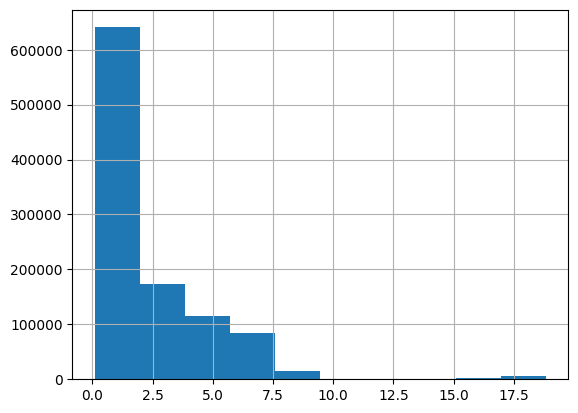

In [17]:
train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()

In [19]:
from multiprocessing import Pool

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:10<00:00, 26.21it/s]


In [20]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.7687


event   tolerance
onset   12           0.227650
        36           0.654584
        60           0.757884
        90           0.798135
        120          0.838610
        150          0.853106
        180          0.871969
        240          0.886272
        300          0.894600
        360          0.901400
wakeup  12           0.338420
        36           0.653698
        60           0.740503
        90           0.783703
        120          0.821802
        150          0.836106
        180          0.854407
        240          0.873756
        300          0.888572
        360          0.897869
dtype: float64

---